### Contents of this notebook

I plotted the number of articles published per month in 2021 to see what months generated the most news articles on Myanmar Now (thus implying they were more eventful). I used a wordcloud to analyze the most common words in the 2021 news headlines, and supplemented the wordcloud with a frequency dictionary to get a sense of how far apart the frequencies of these most featured words are.

I also analyzed what topics have grown or dropped in 2022 using the tags assigned to each news article by the Myanmar Now journalists themselves. I then plotted the frequency of top ten most common tags in 2022. 

In [1]:
import requests
import os
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import plotly.express as px
import time

In [2]:
# download webpages of most read news articles from Feb 2021-Dec 2021

if not os.path.exists("MMN_mostread"):
    os.mkdir("MMN_mostread")
    
    for i in range(40, 150): 
        url = f"https://www.myanmar-now.org/en/most-read?page={i}"
        response = requests.get(url)
        response.raise_for_status()
        
        with open(os.path.join("MMN_mostread", str(i)+".html"), "w", encoding="utf-8") as f:
            f.write(response.text)

In [3]:
# convert each html page to df
def html_to_df(path):

    with open(path, encoding="utf-8") as f:
        html = f.read()
    soup = BeautifulSoup(html)
    data = {}
    news_titles = [title.text.strip() for title in soup.find_all('div', class_ = 'news-title')]
    pub_dates = [date['content'].split('T')[0] for date in soup.find_all('span', class_ = 'date-display-single')]
    data['title'] = news_titles[1:] #removing the highlighted article on each page because it's repeated
    data['date'] = pub_dates[1:]
    
    return pd.DataFrame(data, columns = data.keys())

# append all the dfs into one big df

dfs = []
for i in range(40, 150): 
    df = html_to_df(os.path.join('MMN_mostread', str(i)+'.html'))
    dfs.append(df)
    
big_df = pd.concat(dfs, ignore_index=True)

pd.set_option("display.max_colwidth", None) 
big_df.head()

,title,date
0,More Magway villagers fall victim to marauding regime forces,2022-01-03
1,Junta forces and military-backed armed group terrorise Sagaing residents,2022-01-03
2,Junta township chair killed by guerrilla force’s bomb in Sagaing,2022-01-03
3,"NLD leaders, student activists receive prison sentences in year-end blitz",2021-12-31
4,Cruelty for its own sake: How Myanmar’s junta uses torture as a tool of oppression,2021-12-31


In [4]:
# convert dates from string into datetime object
big_df['date'] = pd.to_datetime(big_df.date, format='%Y-%m-%d')
big_df.head()

,title,date
0,More Magway villagers fall victim to marauding regime forces,2022-01-03
1,Junta forces and military-backed armed group terrorise Sagaing residents,2022-01-03
2,Junta township chair killed by guerrilla force’s bomb in Sagaing,2022-01-03
3,"NLD leaders, student activists receive prison sentences in year-end blitz",2021-12-31
4,Cruelty for its own sake: How Myanmar’s junta uses torture as a tool of oppression,2021-12-31


### Cleaning the dataset to only include news articles from Feb-Dec 2021

In [5]:
# drop the three articles from Jan 2022
df_2021 = big_df.drop([0,1,2])
df_2021 = df_2021.reset_index()
df_2021 = df_2021.drop(columns=['index'])
df_2021.head()

,title,date
0,"NLD leaders, student activists receive prison sentences in year-end blitz",2021-12-31
1,Cruelty for its own sake: How Myanmar’s junta uses torture as a tool of oppression,2021-12-31
2,Resumed clashes near Mongko leave at least a dozen junta soldiers dead,2021-12-31
3,Junta issues order to ignore notifications from international courts,2021-12-30
4,"Junta statement ‘full of lies’, says KNU spokesperson",2021-12-30


In [6]:
df_2021.tail()

,title,date
1312,Aung San Suu Kyi and ousted president Win Myint charged under laws that carry three-year sentences,2021-02-03
1313,Myanmar descends back into dictatorship as military declares state of emergency,2021-02-01
1314,Suu Kyi calls for public resistance against coup,2021-02-01
1315,Domestic election observers urge all parties to accept result of vote,2021-01-30
1316,Tanks appear on city streets as fears of a possible coup continue,2021-01-29


In [7]:
df_2021 = df_2021.drop([1315, 1316])
df_2021.tail()

,title,date
1310,Three Saffron Revolution monks among those detained in February 1 raids,2021-02-03
1311,Veteran activist calls for civil disobedience in wake of coup,2021-02-03
1312,Aung San Suu Kyi and ousted president Win Myint charged under laws that carry three-year sentences,2021-02-03
1313,Myanmar descends back into dictatorship as military declares state of emergency,2021-02-01
1314,Suu Kyi calls for public resistance against coup,2021-02-01


### Plotting number of articles published by month in 2021

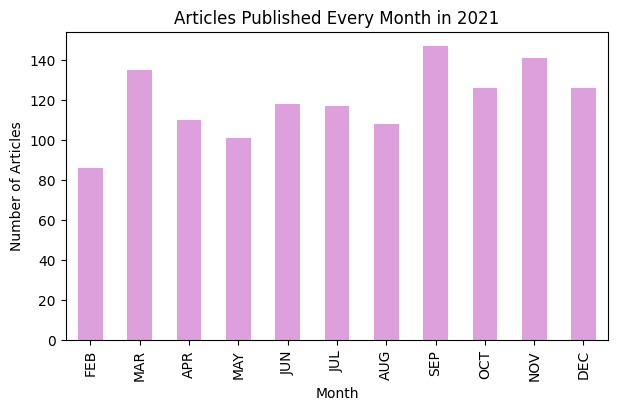

In [8]:
ax = df_2021.groupby(df_2021.date.dt.month)['title'].count().plot(kind='bar', figsize=(7, 4), color='plum')
months = ['FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC']
ax.set_xticklabels(months)
ax.set(xlabel='Month', ylabel='Number of Articles', title="Articles Published Every Month in 2021")
plt.show()

What days had the most articles published?

In [9]:
df_2021['date'].value_counts().head(10)

2021-11-09    9
2021-10-07    8
2021-03-17    8
2021-10-26    8
2021-09-10    8
2021-09-02    8
2021-09-08    8
2021-10-05    8
2021-11-08    7
2021-11-10    7
Name: date, dtype: int64

### A wordcloud of most common headlines words in 2021

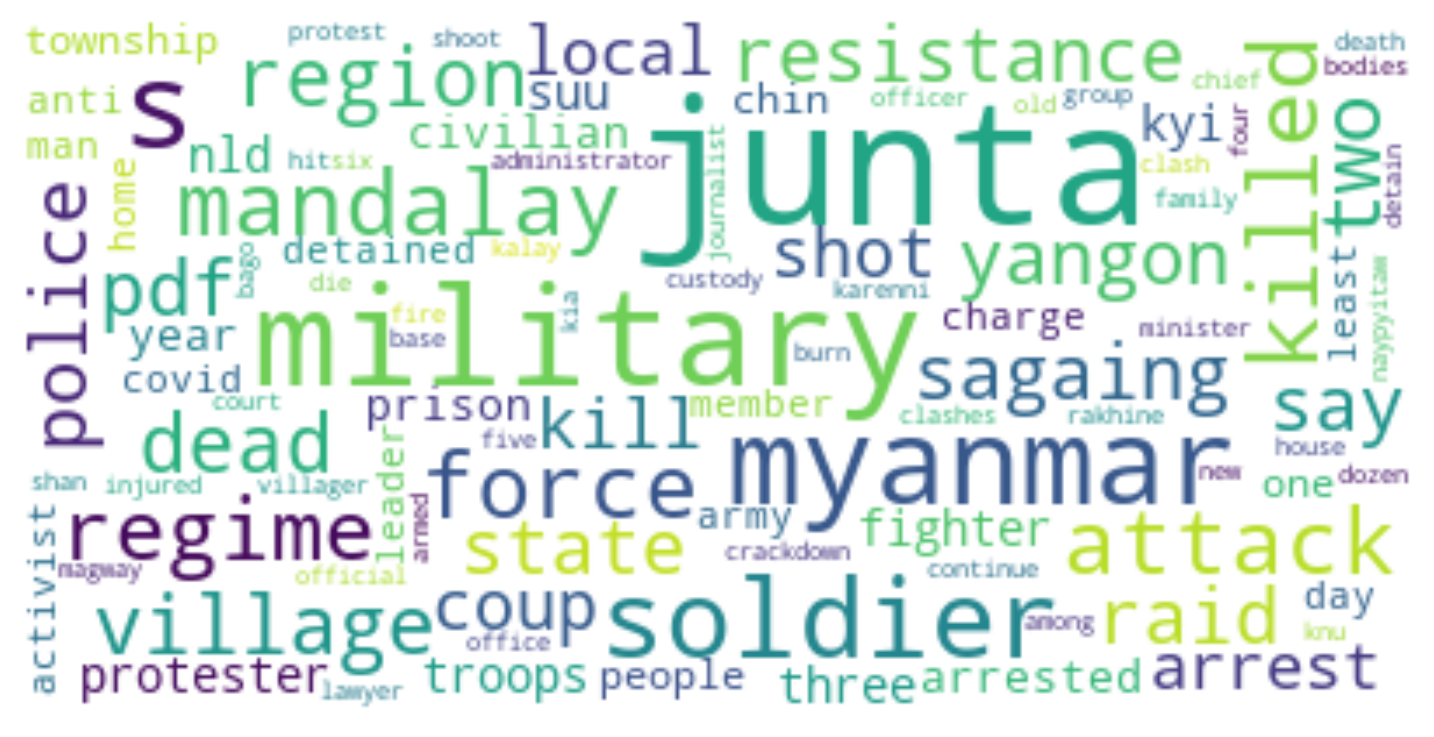

In [10]:
#max_font_size=50, max_words=100
text = " ".join(title.lower() for title in df_2021['title'])
word_cloud = WordCloud(max_font_size=50, max_words=100, collocations = False, background_color = 'white').generate(text)

from matplotlib.pyplot import figure
figure(figsize=(9, 6), dpi=200)

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [11]:
word_cloud.to_file("MMN_mostread\keywords_whitebg.png")

### What are the frequencies of most featured headline words from 2021? 

In [12]:
# make a giant string 
s0 = ''
for title in df_2021['title']:
    s0 += ' '+ title.lower()
s0 = s0.strip()

# make a list of tuples where each tuple is (word,fq)
frequency = [] 
word_ls = s0.split(' ')  # make a list of words from all topics
for w in word_ls:
    frequency.append(word_ls.count(w))  # make a list of word frequencies
    
word_fq = list(zip(word_ls, frequency))

# convert this list into a dict
freqdict = dict(word_fq)

In [13]:
# sort this dict. You can't sort a dict directly, so convert to a list first, sort, then convert back to dict.
def sortSecond(val):
    return val[1]

In [14]:
word_to_fq = [(key, freqdict[key]) for key in freqdict]
word_to_fq.sort(key = sortSecond, reverse = True)

# removing stopwords from the dict
stopwords = ['a', 'about', 'as', 'at', 'against', 'across', 'after', 'by', 'in', 'on', 'to', 'the', 'of', 'and', 'for', 'from', 'with']

wordfreq_dict = dict(word_to_fq)
for k in list(wordfreq_dict.keys()):
    if k in stopwords:
        del wordfreq_dict[k]

# Display the top ten most frequent words in the headlines, and their frequencies.        
k = 15
short_wordfreq_dict = dict(list(wordfreq_dict.items())[0: k])
short_wordfreq_dict

{'junta': 324,
 'military': 203,
 'soldiers': 134,
 'myanmar': 126,
 'mandalay': 102,
 'killed': 102,
 'two': 90,
 'regime': 80,
 'region': 76,
 'dead': 75,
 'forces': 74,
 'resistance': 73,
 'sagaing': 70,
 'police': 70,
 'yangon': 69}

#### Takeaway:

Mandalay and Sagaing, two locations in upper Myanmar, featured more often in news headlines than Yangon in the south, which has the highest number of urban population as the ex-capital of Myanmar. This reaffirms that most of the military attacks on civilians have been concentrated in rural areas in upper Myanmar (in the Mandalay/Sagaing region). 

### What topics have grown or dropped in 2022? 

Why I don't analyze this trend using the headlines I've collected from Feb-Dec 2021:
1. The top ten most common words in the 2021 news headlines contain words with related meanings like (junta, military, soldiers) and (killed and dead). They are not good representations of distinct topics. 
2. Judging from the tags used by the Myanmar Now journalists to categorize their articles, we should look at bigrams or longer to get distinct topics. For example, there is a meaningful difference between words like "junta raid" and "junta airstrikes".
3. The html files I have downloaded about news headlines from 2021 do not contain the tag info I need. 

I will use the Myanmar Now journalists' tagging system to analyze the trend in topics. I need to loop through each news article to extract tags, so I will scrape this info directly from the website instead of downloading each article as an html page. 

In [15]:
article_links = []
for i in range(0, 80): 
    url = f"https://www.myanmar-now.org/en/news?page={i}"
    response = requests.get(url)
    response.raise_for_status()
    html = response.text
    soup = BeautifulSoup(html)
    titles = soup.find_all('div', class_ = 'news-title')
    
    for title in titles: 
        link_tag = title.find('a')
        link = link_tag.get('href')
        article_links.append(link)
    
print(len(article_links))

1040


In [16]:
# Drop duplicate links because some articles are listed twice as I progress through pages.
unique_article_links = []
[unique_article_links.append(link) for link in article_links if link not in unique_article_links]

print('Dropped', len(article_links) - len(unique_article_links), 'duplicate articles leaving', len(unique_article_links), 'unique article links.')

Dropped 133 duplicate articles leaving 907 unique article links.


### Extract tag, date, author info from each article

Note: I get the error message 'NoneType' object has no attribute 'find_all' if I run the following code over a long list of unique_article_links. So I will skip the articles that are generating this error.

In [17]:
main_page_url = 'https://www.myanmar-now.org'
topics_to_date_list = []
start = time.time()

for link in unique_article_links:
    try:       
        article_url = main_page_url + link
        response = requests.get(article_url)
        response.raise_for_status()
        html = response.text
        soup = BeautifulSoup(html)
        date = soup.find('span', class_ = 'date-display-single')
        author = soup.find('div', class_ = 'author-name')
        topic_tags = soup.find('div', class_ = 'field field-name-field-topics field-type-taxonomy-term-reference field-label-hidden view-mode-full')
        tag_list = topic_tags.find_all('a')
       
    except (AttributeError) as e:
        print("Error because:", str(e))
        print("Error is on item", unique_article_links.index(link))
        print("Error with the page", main_page_url + link)
        print("--------")
        
        continue
        
    tag_names = []
    
    for tag in tag_list:
        tag_names.append(tag.text.lower())  
    topics_to_date = (tag_names, date['content'].split('T')[0], author.text)
    topics_to_date_list.append(topics_to_date)

end = time.time()    
print("Dropped", len(unique_article_links)-len(topics_to_date_list), "articles that do not have tags.")

print('This dataset contains information about articles from', topics_to_date_list[0][1], 'to', topics_to_date_list[-1][1], '.')

print('Total time elapsed:', round((end - start)/60, 2), 'minutes.')

Error because: 'NoneType' object has no attribute 'find_all'
Error is on item 6
Error with the page https://www.myanmar-now.org/en/news/teen-dies-in-naypyitaw-detention-centre-after-arrest-for-suspected-involvement-in-bombing
--------
Error because: 'NoneType' object has no attribute 'find_all'
Error is on item 176
Error with the page https://www.myanmar-now.org/en/news/turnell-tests-positive-for-covid-19-transferred-to-yamethin-prison
--------
Error because: 'NoneType' object has no attribute 'find_all'
Error is on item 340
Error with the page https://www.myanmar-now.org/en/news/executions-bring-myanmar-closer-to-the-edge-of-the-abyss
--------
Error because: 'NoneType' object has no attribute 'find_all'
Error is on item 481
Error with the page https://www.myanmar-now.org/en/news/motorbikes-banned-in-kawhmu-after-attack-on-administrator-and-wife
--------
Error because: 'NoneType' object has no attribute 'find_all'
Error is on item 526
Error with the page https://www.myanmar-now.org/en/

In [18]:
# create a df with tags, publication_date, author
topics_dates_df = pd.DataFrame(topics_to_date_list, columns = ['Tags', 'Publication_date', 'Author'])
            
# convert dates into datetime object
topics_dates_df['Publication_date'] = pd.to_datetime(topics_dates_df['Publication_date'], format='%Y-%m-%d')
pd.set_option("display.max_colwidth", None) 
topics_dates_df.head()

,Tags,Publication_date,Author
0,"[laukkai, mndaa]",2022-12-08,Nyein Swe
1,"[natogyi, nld supporters, murders]",2022-12-08,Linn Htin
2,[rohingya],2022-12-08,Sa Tun Aung
3,"[hkalam samson, kbc]",2022-12-08,Nyein Swe
4,"[anti-junta activists, prisoners on death row, student activists]",2022-12-07,Han Thit


### Find the most common tags in this dataset

In [19]:
tag_list_flattened = [tag for tags in topics_dates_df['Tags'] for tag in tags]  # make a giant list with all tags

tag_freq_dict = {}
for tag in tag_list_flattened:
    tag_freq_dict[tag] = tag_list_flattened.count(tag)

In [20]:
# Sort this frequency dictionary of tags.

tag_to_fq = [(key, tag_freq_dict[key]) for key in tag_freq_dict]
tag_to_fq.sort(key = sortSecond, reverse = True)
tag_freq_dict_sorted = dict(tag_to_fq)
# tag_freq_dict_sorted 

In [21]:
# extract the 10 most common tags
most_common_tags = list(tag_freq_dict_sorted.items())[:10]
print("The top ten most common tags are", most_common_tags)

The top ten most common tags are [('armed resistance', 199), ('sagaing region', 186), ("people's defence force", 51), ('magway region', 47), ('rakhine state', 45), ('arakan army', 43), ('military raid', 43), ('junta raid', 39), ('karenni state', 31), ('mandalay', 30)]


### What is the frequency of the most common tags over time?

#### Approach: 

1. Initialize a dictionary where each key is a tag, mapped to an empty list
2. Iterate through the df, if a tag appears in topics_dates_df['Tags'], extract the month from its publication date and append it to the list corresponding to that tag.
3. Count the frequency with which each tag appears in each month.

In [22]:
tag_to_months = {}
for tag in most_common_tags:
    tag_to_months[tag[0]] = []  # initialize a dictionary where key is tag, value is frequency

for tag in tag_to_months:
    for index, data in topics_dates_df.iterrows():
        if tag in data['Tags']:
            tag_to_months[tag].append(data['Publication_date'].date().month)

print(tag_to_months)

{'armed resistance': [12, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'sagaing region': [12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6

In [23]:
def CountFrequency(a_list):
    freq = {}
    for item in a_list:
        if (item in freq):
            freq[item] += 1
        else:
            freq[item] = 1
    return freq

# test
CountFrequency([12, 12, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10])

{12: 2, 11: 4, 10: 6}

In [24]:
nested_dict = {}
for tag in tag_to_months:
    month_to_freq = CountFrequency(tag_to_months[tag])  # this returns a dict
    nested_dict[tag] = month_to_freq
    
print(nested_dict)

{'armed resistance': {12: 5, 11: 20, 10: 11, 9: 9, 8: 9, 7: 23, 6: 24, 5: 22, 4: 14, 3: 23, 2: 19, 1: 20}, 'sagaing region': {12: 4, 11: 17, 10: 15, 9: 15, 8: 15, 7: 18, 6: 16, 5: 19, 4: 5, 3: 25, 2: 24, 1: 13}, "people's defence force": {12: 1, 11: 6, 10: 3, 9: 6, 8: 5, 7: 7, 6: 1, 5: 6, 4: 2, 3: 8, 2: 3, 1: 3}, 'magway region': {11: 6, 10: 5, 9: 2, 8: 5, 7: 5, 6: 8, 5: 6, 4: 1, 3: 8, 2: 1}, 'rakhine state': {12: 1, 11: 6, 10: 7, 9: 5, 8: 4, 7: 1, 6: 9, 5: 6, 4: 3, 3: 3}, 'arakan army': {12: 1, 11: 5, 10: 4, 9: 7, 8: 7, 7: 3, 6: 5, 5: 6, 4: 2, 2: 2, 1: 1}, 'military raid': {11: 1, 7: 1, 6: 5, 3: 15, 2: 19, 1: 2}, 'junta raid': {12: 1, 11: 5, 10: 5, 9: 3, 8: 11, 7: 7, 6: 4, 4: 1, 3: 2}, 'karenni state': {12: 1, 10: 1, 9: 7, 8: 2, 6: 1, 5: 5, 4: 2, 3: 2, 2: 6, 1: 4}, 'mandalay': {11: 3, 10: 4, 9: 1, 8: 2, 7: 3, 6: 5, 5: 4, 4: 2, 3: 3, 2: 3}}


In [25]:
tags = []
months = []
freqs = []

for tag in nested_dict:
    for month in range(1, 13):
        tags.append(tag)
        months.append(month)
        freqs.append(nested_dict[tag].get(month, 0))
tag_freq_df1 = pd.DataFrame(list(zip(tags, months, freqs)), columns = ['Tag', 'Month', 'Frequency'])
tag_freq_df1.to_csv('tag_frequency_data.csv')

In [26]:
tag_freq_df1.head()

,Tag,Month,Frequency
0,armed resistance,1,20
1,armed resistance,2,19
2,armed resistance,3,23
3,armed resistance,4,14
4,armed resistance,5,22


In [30]:
fig = px.line(tag_freq_df1, x = 'Month', y = 'Frequency', color = 'Tag', title = 'Frequency of top ten common tags in 2022 (period covered: 2022/1/7 - 2022/12/8)')
fig.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
        ticktext = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']))

fig.show()

### Isolating the first four most common tags for clearer view

In [28]:
tag_freq_df = pd.DataFrame(nested_dict)
tag_freq_df = tag_freq_df.fillna(0)

narrow_df = tag_freq_df.copy()
narrow_df.drop(narrow_df.iloc[:, 4:], axis = 1, inplace=True)
narrow_df

,armed resistance,sagaing region,people's defence force,magway region
12,5,4,1,0.0
11,20,17,6,6.0
10,11,15,3,5.0
9,9,15,6,2.0
8,9,15,5,5.0
7,23,18,7,5.0
6,24,16,1,8.0
5,22,19,6,6.0
4,14,5,2,1.0
3,23,25,8,8.0


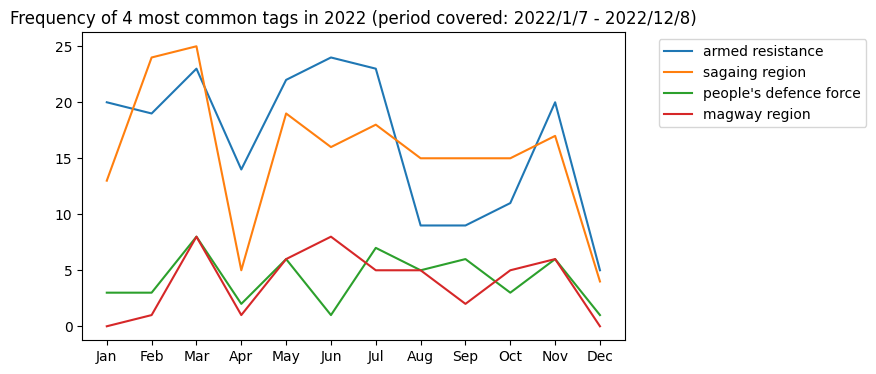

In [31]:
ax = narrow_df.plot(figsize=(7,4), title='Frequency of 4 most common tags in 2022 (period covered: 2022/1/7 - 2022/12/8)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.xticks(ticks = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

#### Takeaways:

The two most common tags in Myanmar Now articles are 'armed resistance' and 'sagaing region'. The frequencies of these two tags are noticeably higher than the frequencies of the other common tags. The frequencies of these two tags follow a similar trend across 2022. It might be worth checking if this is because the two tags often appear together in articles, which might suggest that armed resistance has been concentrated in the sagaing region in upper Myanmar. 

Noteworthy that topics that often appear in international news coverage about Myanmar, like the Rohingya crisis and ethnic minority issues, did not show up in Myanmar Now's most common tags. The tags that are closest to these topics are 'rakhine state', 'arakan army', 'karenni state', and 'knu' - these have much lower frequencies than the top two tags: 'armed resistance' and 'sagaing region'. 

This suggests there seems to be a difference in the types of news reported between the international and local news sources based in Myanmar. Since four of the top ten most common tags in Myanmar Now articles are the names of different regions in Myanmar ('sagaing region', 'magway region', 'rakhine state' and 'karenni state') we can assume that Myanmar Now reports more on developments at the regional level, as opposed to the national level. 